# Quick Start Guide to DESI Data Release 1 

*Stephen Bailey (Berkeley Lab), Ragadeepika Pucha (U.Arizona), Anthony Kremin (Berkeley Lab), Stéphanie Juneau (NOIRLab), Jaime E. Forero-Romero (Uniandes), Farnik Nikakhtar (Yale), Bernardita Ried Guachalla (Stanford), and DESI Data Team*

This tutorial provides a rapid overview of DESI Data Release 1 (DR1), from redshift catalogs through spectra
without requiring any DESI-specific code.
Subsequent tutorials in this directory describe the core concepts in more detail, show how the data are organized on disk,
explore the redshift catalogs and spectra in more depth, and introduce DESI-specific code that facilitates working with the DESI data more conveniently.

If you haven't already, see 00_Setup.md in this directory for how to install the software and download the data necessary for this tutorial.

## Table of Contents

* [Imports](#import)
* [Accessing the data](#data_access)
* [Redshift Catalogs](#zcatalog)
* [Spectra](#spectra)
* [Next Steps](#next_steps)
* [References](#references)

<a class="anchor" id="import"></a>
## Imports and environment check

In [1]:
# import some helpful python packages 
import os
import numpy as np
import fitsio
from astropy.table import Table
import matplotlib.pyplot as plt
## plt.style.use('../mpl/desi.mplstyle')

In [9]:
if 'DESI_ROOT' not in os.environ:
    print("ERROR: Ideally $DESI_ROOT should be set to data location before starting Jupyter")
    if 'NERSC_HOST' in os.environ:
        print('Setting $DESI_ROOT to NERSC DR1 location')
        os.environ['DESI_ROOT'] = '/global/cfs/cdirs/desi/public/dr1'
    else:
        print("ERROR: update this cell to set $DESI_ROOT to your local location of DESI data")
        # os.environ['DESI_ROOT'] = '/path/to/local/desi/tiny_dr1'

In [10]:
# double check
assert 'DESI_ROOT' in os.environ
assert os.path.exists(os.environ['DESI_ROOT'])
assert os.path.exists(os.path.expandvars('$DESI_ROOT/spectro/redux/iron'))

<a class="anchor" id="data_access"></a>
## Accessing the data

DESI Data Release 1 (DR1) includes spectra for ~17 million unique targets from Main survey observations taken from May 2021 through June 2022, as well as a reprocessing of the Survey Validation data previously released in the DESI Early Data Release (EDR).

DESI Data Releases include one or more "spectroscopic productions" (specprod) alphabetically named after mountains; the primary specprod for DR1 is called "iron", named after the Iron mountains in Utah, USA.
These tutorials find the data under `$DESI_ROOT`.  We recommend that all analyses access data releative to `$DESI_ROOT` and a `specprod` variable, which enables them to run at multiple computing sites and quickly adapt to future releases.

In [11]:
# Release directory path
specprod = 'iron'    # Primary spectroscopic production in DR1
desi_root = os.environ['DESI_ROOT']
specprod_dir = f'{desi_root}/spectro/redux/{specprod}'
print(specprod_dir)

/Users/sbailey/desi/tiny_dr1/spectro/redux/iron


In [12]:
# List everything in this directory
os.listdir(specprod_dir)

['zcatalog', 'tiles', 'healpix']

### Important files

1. tiles-iron.fits (or .csv) -- information about the observed tiles (telescope pointings with fibers assigned to specific targets)
2. exposures-iron.fits (or .csv) -- information about individual exposures of tiles
3. zcatalog/ Directory -- redshift catalogs
4. tiles/ Directory -- spectra, coadds, and redshifts, organized per-tile
5. healpix/ Directory -- spectra, coadds, and redshifts based on sky location (healpix)

For the purposes of this Quick Start guide, we will go directly to the redshift catalogs in `zcatalog/v1`

<a class="anchor" id="zcatalog"></a>
## Redshift Catalogs

The redshift catalogs are in the `zcatalog/v1` directory.  Future releases may include additional versions (e.g. `v2`) with alternate formats to make it easier to work with the ever increasing data volume, but for the purposes of DR1, `zcatalog/v1` is the one to use.

In [13]:
# List all the available redshift catalogs

os.listdir(f'{specprod_dir}/zcatalog/v1')

['zall-pix-iron.fits']

The full iron specprod includes multiple different redshift catalogs, with details described in the 04_RedshiftCatalogs.ipynb tutorial.
If you downloaded the DR1 subset for these tutorials, you will see just `zall-pix-iron.fits` which we will use here.

Since this is a rather large file (136 columns by 28 million rows), we will use `fitsio` to read just a subset of the columns.
After reading, we'll wrap this into a `Table` object for nicer printing.  Even with a subset of columns, this can take 30-60 seconds to read.


In [14]:
columns = ['TARGETID', 'SURVEY', 'PROGRAM', 'DESI_TARGET', 'Z', 'SPECTYPE', 'ZWARN', 'DELTACHI2', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'ZCAT_PRIMARY', 'HEALPIX']
zcat = Table(fitsio.read(f'{specprod_dir}/zcatalog/v1/zall-pix-{specprod}.fits', "ZCATALOG", columns=columns))

Summarizing the columns that we read:
* `TARGETID`: a unique integer for each DESI target
* `SURVEY`: DESI operations are split into different survey phases (e.g. main, sv1, sv3)
* `PROGRAM`: a subdivision of SURVEY, split by observing conditions (e.g. dark, bright)
* `DESI_TARGET`: a bit mask recording why each target was selected for observation
* `Z`: the measured redshift
* `SPECTYPE`: the measured spectral type (e.g. GALAXY, QSO, STAR)
* `ZWARN`: a bit mask flag of redshift/spectype fitting problems; 0 is good
* `DELTACHI2`: the difference in the chi2 of the best fit to the next best fit; bigger is better meaning that the best fit is more confidently the single correct solution
* `FLUX_G/R/Z`: object fluxes from imaging (magnitude = 22.5 - 2.5*log10(flux))
* `ZCAT_PRIMARY`: DESI targets can be observed more than once on different tiles / surveys / programs, and thus appear multiple times in a catalog.  This flag indicates which entry is likely the best measurement.
* `HEALPIX`: which nside=64 nested healpixel this target is on (used for finding the actual spectrum on disk)

In [15]:
print(f"Raw number of zcat entries: {len(zcat):,}")
for spectype in ['GALAXY', 'QSO', 'STAR']:
    print(f"Raw number of zcat entries for spectype '{spectype}': {np.sum(zcat['SPECTYPE']==spectype):,}")

Raw number of zcat entries: 28,425,963
Raw number of zcat entries for spectype 'GALAXY': 21,696,490
Raw number of zcat entries for spectype 'QSO': 1,862,583
Raw number of zcat entries for spectype 'STAR': 4,866,890


### Available sources based on Targeting Information

DESI has five main target types; in increasing redshift order these are
1. Milky Way Survey (MWS)
2. Bright Galaxy Survey (BGS)
3. Luminous Red Galaxies (LRG)
4. Emission Line Galaxies (ELG)
5. Quasars (QSO)

Additionally, "secondary" targets are catch-all for various collections of special targets that are interleaved with DESI observations but not a part of the core survey.

Each of these has a bit in `DESI_TARGET`.  For this tutorial we will hardcode which bit is which, and the RedshiftCatalogs tutorial will show how to use DESI specific code to map bit names to bit numbers.
The DESI targeting bits are documented at https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#target-masks, which is where we get the magic numbers below.

In [16]:
desi_tgt = zcat['DESI_TARGET']

is_bgs  = (desi_tgt & 2**60 != 0)
is_lrg  = (desi_tgt & 2**0 != 0)
is_elg  = (desi_tgt & 2**1 != 0)
is_qso  = (desi_tgt & 2**2 != 0)
is_mws  = (desi_tgt & 2**61 != 0)
is_scnd = (desi_tgt & 2**62 != 0)

In [17]:
# Number of sources of each target type
n_bgs = np.count_nonzero(is_bgs)
n_lrg = np.count_nonzero(is_lrg)
n_elg = np.count_nonzero(is_elg)
n_qso = np.count_nonzero(is_qso)
n_mws = np.count_nonzero(is_mws)
n_scnd = np.count_nonzero(is_scnd)

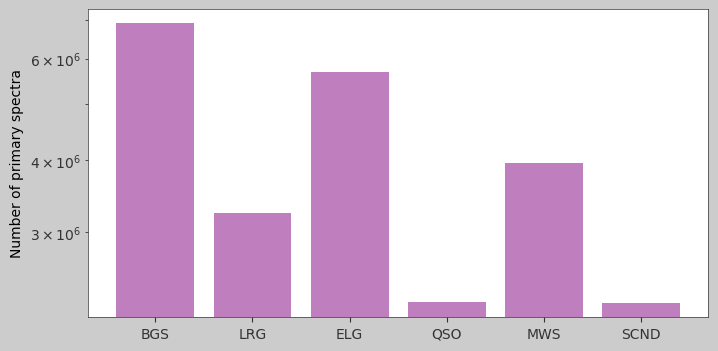

In [18]:
# Let us look at the numbers visually - 

plt.figure(figsize = (8, 4))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
plt.ylabel('Number of primary spectra')
plt.yscale('log')

Text(0.5, 0, 'Redshift')

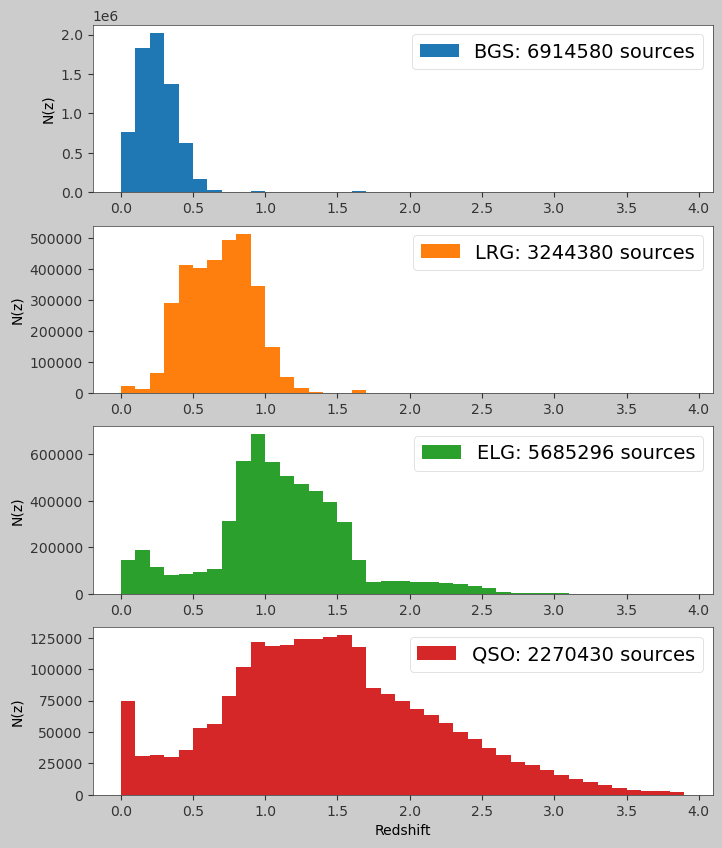

In [19]:
# Now let us look at the distribution of redshifts -

fig, axs = plt.subplots(4, 1, figsize = (8, 10))
bins = np.arange(0, 4, 0.1)

axs[0].hist(zcat['Z'][is_bgs], color = 'C0', bins = bins, label = f'BGS: {n_bgs} sources')
axs[0].legend(fontsize = 14)
axs[0].set_ylabel("N(z)")
axs[1].hist(zcat['Z'][is_lrg], color = 'C1', bins = bins, label = f'LRG: {n_lrg} sources')
axs[1].legend(fontsize = 14)
axs[1].set_ylabel("N(z)")
axs[2].hist(zcat['Z'][is_elg], color = 'C2', bins = bins, label = f'ELG: {n_elg} sources')
axs[2].legend(fontsize = 14)
axs[2].set_ylabel("N(z)")
axs[3].hist(zcat['Z'][is_qso], color = 'C3', bins = bins, label = f'QSO: {n_qso} sources')
axs[3].legend(fontsize = 14)
axs[3].set_ylabel("N(z)")
axs[3].set_xlabel("Redshift")


Now, we will explore how to access the underlying spectra

<a class="anchor" id="spectra"></a>
## Spectra

DESI observes a set of overlapping *tiles* on the sky, with 5000 spectra per tile.
The spectra from each tile are processed together, including coadding multiple exposures
of the same tile.  The data from this tiles-based processing are under the `tiles/` subdirectory.

Some targets, like high redshift quasars, are observed on multiple tiles.  In order to coadd
all available data across tiles for each target and to group data for a given patch of sky
together, a separate processing is grouped by *healpixel* on the sky under the `healpix/` subdirectory.
Healpixels are processed separately for each *survey* and *program* so that the targeting and observing
choices of one survey/program do not impact the uniformity of other survey/programs.

Since most analyses will use the spectra in the `healpix/` directory, we will focus on that for this
QuickStart tutorial, and explore the `tiles/` directory in other tutorials.

### `healpix/` Directory

Spectra are grouped by `healpix/SURVEY/PROGRAM/HPIXGROUP/HEALPIX`/ where
* `SURVEY`: DESI operations are split into different survey phases (e.g. main, sv1, sv3)
* `PROGRAM`: a subdivision of `SURVEY`, split by observing conditions (e.g. dark, bright)
* `HPIXGROUP`: `int(HEALPIX/100)` in order to avoid thousands of healpix directories all at the same level
* `HEALPIX`: the nside=64 nested-scheme healpix number

We'll explore the data under one particular healpixel (23040) included in the tiny_dr1 subset of data.

In [20]:
healpix_dir = f'{specprod_dir}/healpix'
survey = 'main'
program = 'dark'
healpix = 23040
hpixgroup = healpix//100

In [21]:
os.listdir(healpix_dir)

['main']

In [22]:
os.listdir(f'{healpix_dir}/{survey}')

['dark']

In [23]:
sorted(os.listdir(f'{healpix_dir}/{survey}/{program}'))[0:10]

['230']

In [24]:
sorted(os.listdir(f'{healpix_dir}/{survey}/{program}/{hpixgroup}'))[0:10]

['23040']

In [25]:
sorted(os.listdir(f'{healpix_dir}/{survey}/{program}/{hpixgroup}/{healpix}'))

['coadd-main-dark-23040.fits',
 'emline-main-dark-23040.fits',
 'hpixexp-main-dark-23040.csv',
 'qso_mgii-main-dark-23040.fits',
 'qso_qn-main-dark-23040.fits',
 'redrock-main-dark-23040.fits',
 'redux_iron_healpix_main_dark_230_23040.sha256sum',
 'rrdetails-main-dark-23040.h5',
 'spectra-main-dark-23040.fits.gz']

The data files in a healpix directory are:
* `spectra-SURVEY-PROGRAM-HEALPIX.fits.gz`: uncoadded spectra
* `coadd-SURVEY-PROGRAM-HEALPIX.fits`: spectra coadded across tiles and exposures for each TARGETID
* `redrock-SURVEY-PROGRAM-HEALPIX.fits`: Redshift and spectype classifications (STAR, GALAXY, QSO) from the Redrock fitter
* `rrdetails-SURVEY-PROGRAM-HEALPIX.h5`: Further details for each target from Redrock
* `emline-SURVEY-PROGRAM-HEALPIX.fits`: Basic Gaussian fits to common emission lines
* `qso_mgii-SURVEY-PROGRAM-HEALPIX.fits`: Fits to the [MgII] line for QSO identification
* `qso_qn-SURVEY-PROGRAM-HEALPIX.fits`: QSO identification from the QuasarNET algorithm

Other files: `hpixexp*.csv` tracks the input exposures for this healpix, and `*.sha256sum` includes the checksums for data verification after downloading.


### Accessing and Plotting Spectra of a Single Object

To determine the coadded spectra file for a particular target, we need the following information:

* `SURVEY`
* `PROGRAM`
* `HEALPIX`

The coadd filepath can be created using this -
```
{specprod_dir}/healpix/{survey}/{program}/{hpixgroup}/{healpix}/coadd-{survey}-{program}-{healpix}.fits
```
Where `hpixgroup = healpix//100` or equivalently `int(healpix/100)`.

Let's explore the format of the coadd file

In [26]:
# Set survey/program/healpix again in case previous cells modified this while exploring
survey = 'main'
program = 'dark'
healpix = 23040
hpixgroup = healpix//100

# Filename
coadd_filepath = f'{specprod_dir}/healpix/{survey}/{program}/{hpixgroup}/{healpix}/coadd-{survey}-{program}-{healpix}.fits'

In [27]:
h_coadd = fitsio.FITS(coadd_filepath)
h_coadd


  file: /Users/sbailey/desi/tiny_dr1/spectro/redux/iron/healpix/main/dark/230/23040/coadd-main-dark-23040.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      BINARY_TBL      EXP_FIBERMAP
  3      IMAGE_HDU       B_WAVELENGTH
  4      IMAGE_HDU       B_FLUX
  5      IMAGE_HDU       B_IVAR
  6      IMAGE_HDU       B_MASK
  7      IMAGE_HDU       B_RESOLUTION
  8      IMAGE_HDU       R_WAVELENGTH
  9      IMAGE_HDU       R_FLUX
  10     IMAGE_HDU       R_IVAR
  11     IMAGE_HDU       R_MASK
  12     IMAGE_HDU       R_RESOLUTION
  13     IMAGE_HDU       Z_WAVELENGTH
  14     IMAGE_HDU       Z_FLUX
  15     IMAGE_HDU       Z_IVAR
  16     IMAGE_HDU       Z_MASK
  17     IMAGE_HDU       Z_RESOLUTION
  18     BINARY_TBL      SCORES

We can see that every coadd* file has a blank HDU0 and 18 extensions with data:
* **FIBERMAP** Table of information about the different targets
* **EXP_FIBERMAP** Table of exposure information of the targets
* For every camera (**B**, **R**, **Z**), we have
  * **WAVELENGTH**: the 1D wavelength array for all spectra on that camera (Angstroms)
  * **FLUX**: 2D[nspec,nwave] spectral flux (10^-17 erg/s/cm2/Angstrom)
  * **IVAR**: 2D[nspec,nwave] inverse variance of FLUX
  * **RESOLUTION**: diagonals of a matrix defining the per-fiber wavelength-dependent instrument resolution
* **SCORES** Table of quality scores measures from the spectra

Detailed datamodel is available [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/coadd-SURVEY-PROGRAM-PIXNUM.html). <br/>

Let's plot the position of different sources in the sky and color by targeting type.

In [28]:
fm = Table(h_coadd['FIBERMAP'].read())
desi_tgt = fm['DESI_TARGET']
is_lrg  = (desi_tgt & 2**0 != 0)
is_elg  = (desi_tgt & 2**1 != 0)
is_qso  = (desi_tgt & 2**2 != 0)
is_other = ~is_lrg & ~is_elg & ~is_qso

n_lrg = np.count_nonzero(is_lrg)
n_elg = np.count_nonzero(is_elg)
n_qso = np.count_nonzero(is_qso)
n_other = np.count_nonzero(is_other)

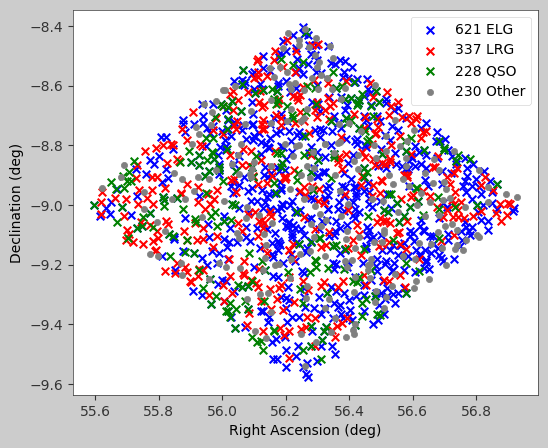

In [29]:
plt.figure(figsize = (6, 5))

plt.scatter(fm['TARGET_RA'][is_elg], fm['TARGET_DEC'][is_elg], color='blue', s=30, marker='x', label=f'{n_elg} ELG')
plt.scatter(fm['TARGET_RA'][is_lrg], fm['TARGET_DEC'][is_lrg], color='red', s=30, marker='x', label=f'{n_lrg} LRG')
plt.scatter(fm['TARGET_RA'][is_qso], fm['TARGET_DEC'][is_qso], color='green', s=30, marker='x', label=f'{n_qso} QSO')
plt.scatter(fm['TARGET_RA'][is_other], fm['TARGET_DEC'][is_other], color = 'grey', s = 20, label = f'{n_other} Other')
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.legend()

The diamond shape comes from the healpix grouping.  On this healpix, ELGs are the most numerous target type, followed by LRGs and QSOs.  The other targets are standard stars, sky fibers, and possibly various secondary targets.

### Select a spectrum

Now we'll go back to the redshift catalog `zcat` to select the `TARGETID` of a QSO to plot.

In [30]:
# Select targets
sel = (zcat['HEALPIX'] == healpix)
sel &= (zcat['SPECTYPE'] == 'QSO') 
sel &= (zcat['Z'] > 2)
sel &= (zcat['ZWARN'] == 0)  # 0 is good, i.e. no warning bits set
zpix = zcat[sel]

zpix

TARGETID,SURVEY,PROGRAM,HEALPIX,Z,ZWARN,SPECTYPE,DELTACHI2,FLUX_G,FLUX_R,FLUX_Z,DESI_TARGET,ZCAT_PRIMARY
int64,str7,str6,int32,float64,int64,str6,float64,float32,float32,float32,int64,bool
39627557057859376,main,dark,23040,2.8129061743517765,0,QSO,871.7564671933651,2.8436928,3.5212715,3.7957993,262148,True
39627557057859548,main,dark,23040,2.810950134756959,0,QSO,1528.187849232927,0.26132342,0.7171656,0.6502857,262148,True
39627557057860189,main,dark,23040,2.52108547031936,0,QSO,248.6104701925069,3.6294696,5.5573854,7.8873525,4611686018427650052,True
39627557057860246,main,dark,23040,2.9426677692782808,0,QSO,2926.765632953495,2.7342775,4.547056,6.512161,262148,True
39627557062050877,main,dark,23040,3.3036170662934508,0,QSO,7585.288006559014,2.6440065,3.588695,3.275737,262148,True
39627557062051402,main,dark,23040,2.0144612799383226,0,QSO,204.58626944525167,0.9467513,1.0031365,1.4525832,917606,True
39627557062052432,main,dark,23040,2.3166807019872766,0,QSO,2681.6407823376358,2.364409,2.0831344,3.3776965,4611686018428305446,True
39627557062054449,main,dark,23040,2.487329160871063,0,QSO,128.77232262818143,0.93565553,1.0889736,1.6173478,917542,True
39627563017964714,main,dark,23040,3.0909676562484925,0,QSO,26116.075196877122,6.302259,8.365573,8.993384,262148,True


In [31]:
# Sort by FLUX_G so that we get the brightest targets
isort = np.argsort(zpix['FLUX_G'])
zpix = zpix[isort]

In [32]:
# Determine the row number of the brightest QSO
targetid = zpix['TARGETID'][-1]   # [-1] = last element = brightest object
redshift = zpix['Z'][-1]

i = np.where(fm['TARGETID'] == targetid)[0][0]
print(f'TARGETID={targetid} is row {i} of the fibermap')

TARGETID=39627563026354671 is row 360 of the fibermap


### Plot a spectrum from the coadd file

In [33]:
# read the data into dictionaries keyed by camera
wave = dict()
flux = dict()
for camera in ['B', 'R', 'Z']:
    wave[camera] = h_coadd[f'{camera}_WAVELENGTH'].read()
    flux[camera] = h_coadd[f'{camera}_FLUX'].read()

Text(0.5, 1.0, 'TARGETID=39627563026354671 is QSO at z=2.001')

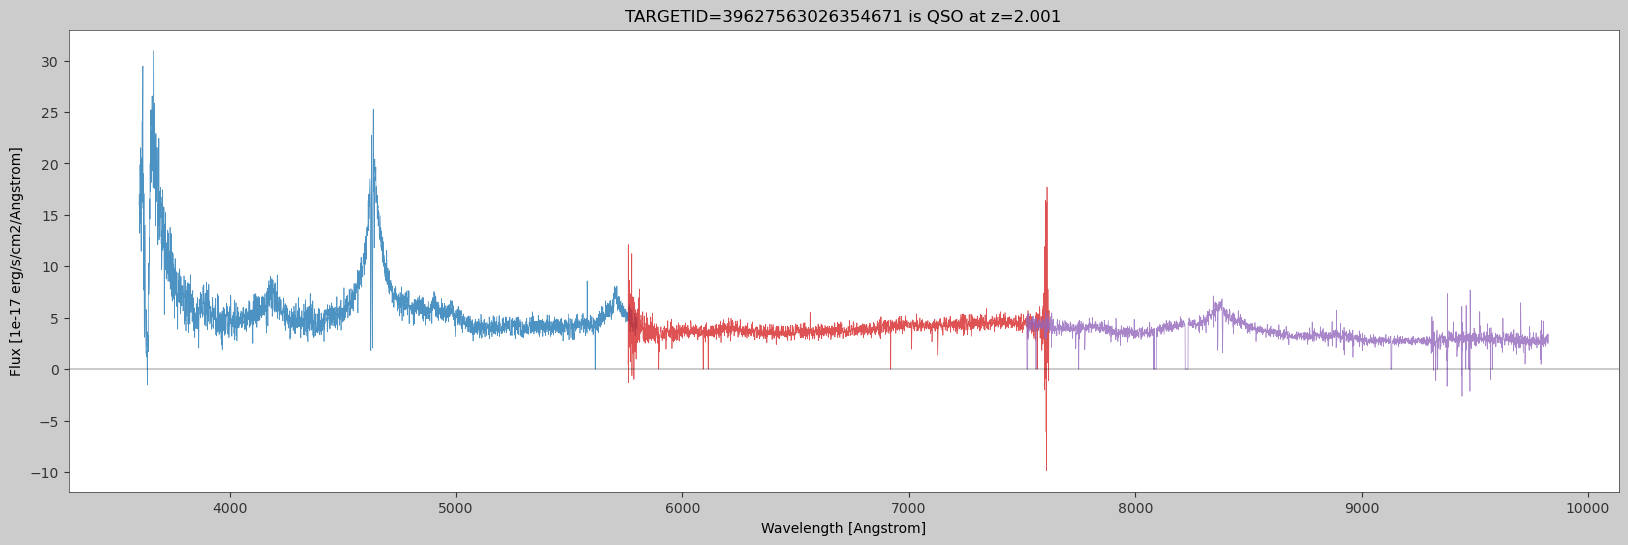

In [34]:
# plot the spectra for the i'th target

plt.figure(figsize = (20, 6))
plt.plot(wave['B'], flux['B'][i], color='C0', lw=0.5, alpha=0.8)
plt.plot(wave['R'], flux['R'][i], color='C3', lw=0.5, alpha=0.8)
plt.plot(wave['Z'], flux['Z'][i], color='C4', lw=0.5, alpha=0.8)
plt.axhline(0, color='k', alpha=0.2)
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Flux [1e-17 erg/s/cm2/Angstrom]')
plt.title(f'TARGETID={targetid} is QSO at z={redshift:0.3f}')

<a class="anchor" id="next_steps"></a>
## Next Steps

The following tutorials will explore these concepts in more detail
* **02_CoreConcepts.ipynb**: Basic concepts and terminology for the DESI survey
* **03_DataOrganization.ipynb**: How the data are organized on disk
* **04_RedshiftCatalogs.ipynb**: More information about the types of redshift catalogs and their contents
* **05_Spectra.ipynb**: More details about the spectra and coadd files and tools for working with them

<a class="anchor" id="references"></a>
## References

* Technical papers and science highlights: https://data.desi.lbl.gov/doc/papers/
* Information about DR1: https://data.desi.lbl.gov/public/dr1
* Information about EDR: https://data.desi.lbl.gov/public/edr
* Targetting Information: 
    * [SV1, SV2, SV3](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract) (Section 2.3.)
    * [main](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract) survey
* Datamodel information: https://desidatamodel.readthedocs.io/en/latest/
    * [tiles-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles-SPECPROD.html)
    * [exposures-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/exposures-SPECPROD.html)
    * [Redshift catalogs](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/index.html)
    * [zall-pix-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-pix-SPECPROD.html)
    * [zall-tilecumulative-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-tilecumulative-SPECPROD.html)
    * [zpix-SURVEY-PROGRAM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)
    * [ztile-SURVEY-PROGRAM-GROUPTYPE.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)
    * [coadd-SURVEY-PROGRAM-PIXNUM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/coadd-SURVEY-PROGRAM-PIXNUM.html)
    * [redshift-SURVEY-PROGRAM-PIXNUM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/redrock-SURVEY-PROGRAM-PIXNUM.html)
* Information about DESI bitmasks: https://desidatamodel.readthedocs.io/en/latest/bitmasks.html
* Redrock Template Tutorial: https://github.com/desihub/tutorials/blob/main/redrock/RedrockOutputs.ipynb